In [ ]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip filters.zip

Archive:  filters.zip
replace __MACOSX/._filters? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
len(os.listdir('filters'))

400

In [ ]:
def get_and_show_dataset(num_images, plot=False):
  if plot:
    _, axarr = plt.subplots(num_images, 16, figsize=(10, num_images))
    plt.axis('off')
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir('filters'))):
    filter = torch.load('filters/' + file)
    for i in range(16):
      weight_dataset.append(filter['0.weight'][i][0])
      if f < num_images:
        if plot:
          axarr[f, i].set_axis_off()
          axarr[f, i].imshow(filter['0.weight'][i][0], interpolation=None)
  return weight_dataset

400it [00:00, 1403.44it/s]


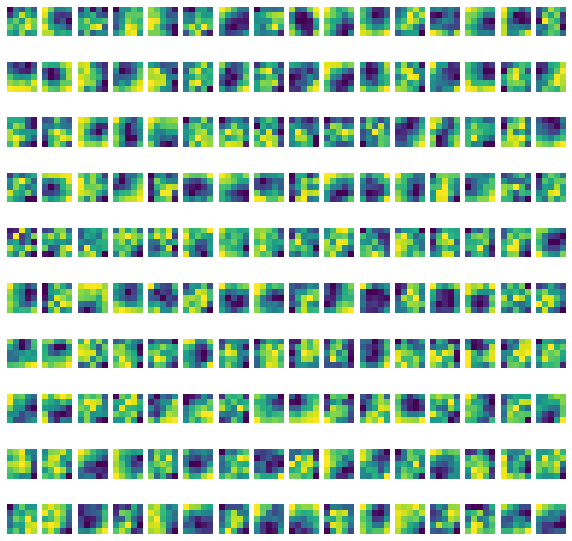

In [ ]:
num_images = len(os.listdir('filters'))
dataset = get_and_show_dataset(10, plot=True)

0
1
2
3
4
5


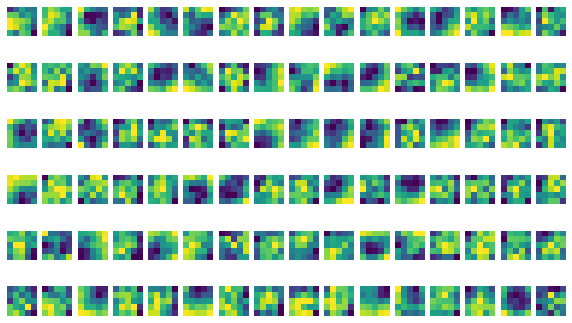

In [ ]:
num_images = 6
_, axarr = plt.subplots(num_images, 16, figsize=(10, num_images))

f = 0
while True:
  if f >= num_images:
    break
  print(f)
  file = np.random.choice(os.listdir('filters'), replace=True)
  filter = torch.load('filters/' + file)
  for i in range(16):
      axarr[f, i].set_axis_off()
      axarr[f, i].imshow(filter['0.weight'][i][0], interpolation=None)
  f += 1

0
1
2
3
4
5


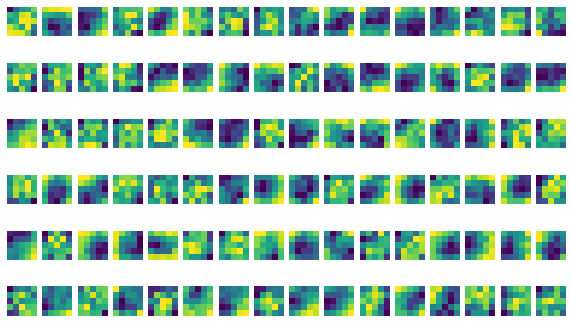

In [ ]:
num_images = 6
_, axarr = plt.subplots(num_images, 16, figsize=(10, num_images))

f = 0
while True:
  if f >= num_images:
    break
  print(f)
  for i in range(16):
      file = np.random.choice(os.listdir('filters'), replace=True)
      filter = torch.load('filters/' + file)

      axarr[f, i].set_axis_off()
      idx = np.random.choice(16)
      
      axarr[f, i].imshow(filter['0.weight'][idx][0], interpolation=None)
  f += 1

In [ ]:
dataset = torch.stack(dataset, dim=0)

In [ ]:
dataset.shape

torch.Size([6400, 5, 5])

VAE

In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


vae_batch_size = 100

x_dim  = 25
hidden_dim = 10
latent_dim = 5

lr = 1e-3

epochs = 50

In [ ]:
from torch.utils.data import DataLoader

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=vae_batch_size, shuffle=True, **kwargs)

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [ ]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.view(vae_batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*vae_batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  15.38865711999318
	Epoch 2 complete! 	Average Loss:  -106.86056744287885
	Epoch 3 complete! 	Average Loss:  -427.5094125124008
	Epoch 4 complete! 	Average Loss:  -494.032552703373
	Epoch 5 complete! 	Average Loss:  -514.1037692212302
	Epoch 6 complete! 	Average Loss:  -527.9576822916666
	Epoch 7 complete! 	Average Loss:  -529.0345269097222
	Epoch 8 complete! 	Average Loss:  -531.5194072420635
	Epoch 9 complete! 	Average Loss:  -529.5211117311508
	Epoch 10 complete! 	Average Loss:  -524.506261780754
	Epoch 11 complete! 	Average Loss:  -526.7101897321429
	Epoch 12 complete! 	Average Loss:  -526.8755326140873
	Epoch 13 complete! 	Average Loss:  -527.9519884672619
	Epoch 14 complete! 	Average Loss:  -527.2447842261905
	Epoch 15 complete! 	Average Loss:  -532.6150489831349
	Epoch 16 complete! 	Average Loss:  -541.6557986111111
	Epoch 17 complete! 	Average Loss:  -541.9784790426587
	Epoch 18 complete! 	Average Loss:  -552.2921899801587

In [ ]:
with torch.no_grad():
    noise = torch.randn(1, latent_dim).to(DEVICE)
    generated_images = decoder(noise)
    print(generated_images.view(5, 5).detach().clone())
    # net[0].weight[c,:,:,:] = generated_filter[0].view(5, 5)


tensor([[0.4403, 0.5800, 0.4901, 0.5438, 0.5526],
        [0.4408, 0.4574, 0.5744, 0.4397, 0.4937],
        [0.4284, 0.4479, 0.4516, 0.4166, 0.5826],
        [0.5082, 0.4861, 0.5037, 0.5065, 0.4669],
        [0.4119, 0.5623, 0.5394, 0.4710, 0.5193]], device='cuda:0')


In [ ]:
def show_image(x, idx):
    x = x.view(vae_batch_size, 5, 5)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

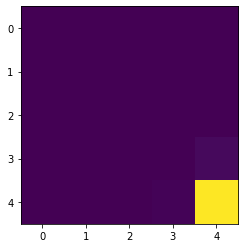

In [ ]:
show_image(generated_images, idx=12)

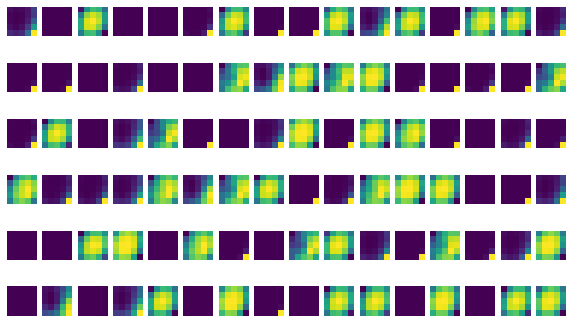

In [ ]:
num_images = 100//16
_, axarr = plt.subplots(num_images, 16, figsize=(10, num_images))

x = generated_images
x = x.view(vae_batch_size, 5, 5)

for i in range(num_images):
  for j in range(16):
    axarr[i, j].set_axis_off()
    axarr[i, j].imshow(x[16*i+j].cpu().numpy(), interpolation=None)

1. Joint sampling

In [ ]:
dataset = get_and_show_dataset(10, plot=True)

In [ ]:
for idx in range(len(x)):
  show_image(generated_images, idx)

Evaluate Model

In [ ]:
from random import shuffle
import uuid
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
import os
from uuid import uuid4
from scipy.special import logsumexp

import numpy as np
from datetime import datetime

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

mnist_mean, mnist_std = (0.1307,), (0.3081,)
mnist_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
    ])
mnist_train = datasets.MNIST('../../data', train=True, download=True,
                    transform=mnist_transform)

mnist_train, mnist_val = random_split(mnist_train, [int(.9*len(mnist_train)),int(.1*len(mnist_train))], generator=torch.Generator().manual_seed(10708))
mnist_test = datasets.MNIST('../../data', train=False,
                    transform=mnist_transform)

cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [ ]:
baseline_sample_counts = [16, 32, 64, 128, 256]

baseline_performances = {
    'vae_IID': {
        'acc': [],
        'loss': []
    }
}
for count in baseline_sample_counts:
    baseline_performances[f'vae_IID_{count}'] = {}
    baseline_performances[f'vae_IID_{count}']['acc'] = []
    baseline_performances[f'vae_IID_{count}']['loss'] = []

uuids = os.listdir('filters')

batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_val,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True)

In [ ]:
# Training params

import pickle

lr = 1e-1
repetitions = 25

count_linear_layer_map = {
    16: 2304*(16//16),
    32: 2304*(32//16),
    64: 2304*(64//16),
    128: 2304*(128//16),
    256: 2304*(256//16),
}

random_noise = False
start_training = datetime.now()
for repetition in range(repetitions):
    for count in baseline_sample_counts:
        # if repetition == 0:
        #   if count != 256:
        #     continue
        # Sample full baseline
        net = nn.Sequential(
            nn.Conv2d(1, count, kernel_size=5, stride=2, bias=False),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(count_linear_layer_map[count], 10)
        ).to(device)

        with torch.no_grad():
            for c in range(count):
              if random_noise:
                net[0].weight[c,:,:,:] =  torch.randn(5, 5).to(DEVICE)
              else:
                noise = torch.randn(1, latent_dim).to(DEVICE)
                generated_filter = decoder(noise)
                net[0].weight[c,:,:,:] = generated_filter[0].view(5, 5).detach().clone()

        optimizer = optim.Adadelta(net.parameters(), lr=lr)

        # https://github.com/pytorch/examples/blob/main/mnist/main.py

        net.train()
        val_losses = []
        val_accs = []
        epoch = 0
        while True:
            net.train()
            for layer in net[0:3]:
                layer.requires_grad = False
            net[3].requires_grad = True
            print(f'Repetition {repetition+1} of {repetitions}, Count of filters {count}, Epoch {epoch+1} , {datetime.now() - start_training}')

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = net(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                optimizer.step()

            net.eval()
            num_correct, num_all, val_loss_l, val_acc = 0, 0, [], 0
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(val_loader):
                    data, target = data.to(device), target.to(device)
                    output = net(data)
                    preds = output.argmax(dim=1)
                    num_correct += np.count_nonzero(target.cpu().numpy() == preds.cpu().numpy())
                    num_all += len(target)
                    val_loss_l.append(F.nll_loss(output, target).cpu().numpy())

            val_accs.append(num_correct/num_all)
            val_losses.append(logsumexp(val_loss_l))

            if len(val_losses)>=2:
                print("(", val_losses[-1], "<-", val_losses[-2], ")")
            if len(val_losses)>=2 and val_losses[-1] > val_losses[-2]:
                print(len(val_losses))
                break
            if epoch > 25:
              print("here")
              break
            epoch += 1


        # Final eval on Test

        net.eval()
        num_correct, num_all, test_loss = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                output = net(data)
                preds = output.argmax(dim=1)
                num_correct += np.count_nonzero(target.cpu().numpy() == preds.cpu().numpy())
                num_all += len(target)
                test_loss += F.nll_loss(output, target)

        acc = num_correct / num_all
        test_loss = test_loss / num_all
        baseline_performances[f'vae_IID_{count}']['acc'].append(acc)
        baseline_performances[f'vae_IID_{count}']['loss'].append(test_loss)
        print("RESULT", count, acc)
        with open('save_baselines.pickle', 'wb') as handle:
            pickle.dump(baseline_performances, handle, protocol=pickle.HIGHEST_PROTOCOL)

Repetition 1 of 25, Count of filters 16, Epoch 1 , 0:00:00.011050
Repetition 1 of 25, Count of filters 16, Epoch 2 , 0:00:14.131388
( -701274700000.0 <- -34022531000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 3 , 0:00:24.244006
( -1845696100000.0 <- -701274700000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 4 , 0:00:34.414503
( -3050341700000.0 <- -1845696100000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 5 , 0:00:44.555128
( -4398905000000.0 <- -3050341700000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 6 , 0:00:54.696636
( -5538138000000.0 <- -4398905000000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 7 , 0:01:05.724724
( -6562251000000.0 <- -5538138000000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 8 , 0:01:16.125343
( -7215049000000.0 <- -6562251000000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 9 , 0:01:26.597158
( -8107710000000.0 <- -7215049000000.0 )
Repetition 1 of 25, Count of filters 16, Epoch 10 , 0:01:36.661315
( -914842100000

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [ ]:
import math

import torch
import torch.nn as nn


def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 500):
    input_length = int(math.log(max_int, 2))

    # Models
    generator = Generator(input_length)
    discriminator = Discriminator(input_length)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)

        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        # add .detach() here think about this
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()

In [ ]:
data[0].shape

torch.Size([1, 5, 5])